<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [6]:
#%%capture
#%pip install requests nltk gensim datasets evaluate transformers

In [ ]:
import gc
import os
import requests
from pathlib import Path
import re
import json
from typing import OrderedDict
import copy


import unicodedata

import numpy as np
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.downloader as gloader

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import evaluate


from detector import SexismDetector

In [8]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Class definition

# Task 1: Corpus

1. Download the data
2. Load the JSON files and encode them as a DataFrame
3. Generate hard labels for Task 1 with majority voting
4. Filter the DataFrame for only english tweets
5. Remove unwanted columns
6. Encode the hard labels column as integers

>**Bonus**: explore also Spanish tweets leveraging multi-language models and assessing the performance of the model on the two languages in comparison to the English-only model.

Fist of all, we need to instantiate the class which we will use to perform the task.

In [9]:
detector = SexismDetector()

Let's define the device to use for the computation of PyTorch

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Reproducibility

The environment variable as well as the seed are set to ensure reproducibility of the results.

In [11]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.cuda.manual_seed(detector.SEED)
np.random.seed(detector.SEED)

### Constants

The constants are defined in the following cell. We will use them to define the embedding dimension and batch size.

In [12]:
EMBEDDING_DIM = 50
BATCH_SIZE = 64
HIDDEN_DIM = 128
EPOCHS = 50
LEARNING_RATE = 1e-4

### Download the data

The data is downloaded from the repository of the course. The `download_corpus` method is used to download the data from the repository and save it in the `data` folder under the root directory of the project.

In [13]:
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/training.json', filename='training.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/test.json', filename='test.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/validation.json', filename='validation.json')

### Load the JSON files and encode them as a DataFrame

Then we load the JSON files and encode them as a DataFrame. The `load_corpus` method is used to load the data from the JSON files and encode them as a DataFrame.

In [14]:
train = detector.load_corpus('training.json', orient='index', encoding='utf-8')
val = detector.load_corpus('validation.json', orient='index', encoding='utf-8')
test = detector.load_corpus('test.json', orient='index', encoding='utf-8')

Make a copy of the test set to be used at the end to perform more in depth analysis about why the model is failing to classify the tweets.

In [15]:
test_copy = test.copy()

We can also inspect the first rows of the DataFrame to have an idea of the data we are working with.

In [16]:
train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


And of course we can also inspect the shape of the DataFrame to know how many rows and columns we have.

In [17]:
train.shape, val.shape, test.shape

((6920, 11), (726, 11), (312, 11))

### Generate hard labels for Task 1 with majority voting

The hard labels for Task 1 are generated with majority voting. The `majority_voting` method is used to generate the hard labels for Task 1 with majority voting. In case of a tie, the label is set to `NEUTRAL` allowing for later filtering of the data.

In [18]:
train['hard_label_task1'] = train['labels_task1'].apply(detector.majority_voting)
val['hard_label_task1'] = val['labels_task1'].apply(detector.majority_voting)
test['hard_label_task1'] = test['labels_task1'].apply(detector.majority_voting)

### Filter the DataFrame for only english tweets and remove unclear tweets

Since the task requires to work only with English tweets, we filter the DataFrame for only English tweets. This can be easily done using basic pandas functionalities. Here we also removed all the rows with unclear labels (ties in the majority voting).

In [19]:
train = train[(train['hard_label_task1'] != "NEUTRAL") & (train['lang'] == "en")]
val = val[(val['hard_label_task1'] != "NEUTRAL") & (val['lang'] == "en")]
test = test[(test['hard_label_task1'] != "NEUTRAL") & (test['lang'] == "en")]

As we can see we have less rows than before, since we removed all the rows with unclear labels and all the rows with tweets in languages different from English.

In [20]:
train.shape, val.shape, test.shape

((2870, 12), (158, 12), (286, 12))

### Remove unwanted columns

After that, we remove the unwanted columns from the DataFrame to keep only the columns we need for the task (the text of the tweet and the hard labels).

In [21]:
train = train[detector.columns_to_maintain]
val = val[detector.columns_to_maintain]
test = test[detector.columns_to_maintain]

In [22]:
train.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,200006,en,According to a customer I have plenty of time ...,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,200008,en,New to the shelves this week - looking forward...,NO


### Encode the hard labels column as integers

Finally, we encode the hard labels column as integers. This is done to have the labels in a format that can be used by the model.

In [23]:
train['hard_label_task1'] = train['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
val['hard_label_task1'] = val['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
test['hard_label_task1'] = test['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)

### Rename the target column to label

In [24]:
train.rename(columns={'hard_label_task1': 'label'}, inplace=True)
val.rename(columns={'hard_label_task1': 'label'}, inplace=True)
test.rename(columns={'hard_label_task1': 'label'}, inplace=True)

The distribution of the labels is also shown to have an idea of the distribution of the labels in the dataset. As we can see there are more non-sexist tweets than sexist tweets in a ratio of 60:40. This is important to know since it can affect the performance of the model.

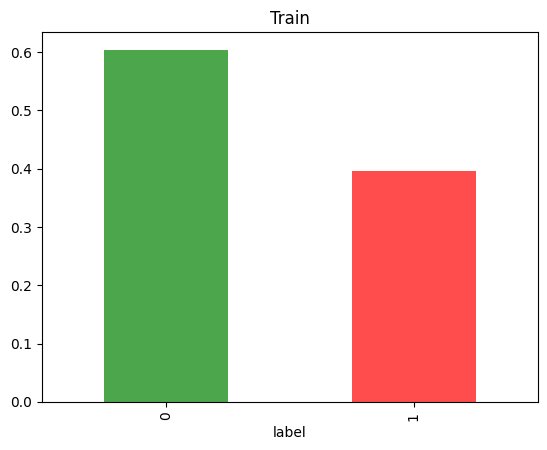

In [25]:
train.label.value_counts(normalize=True).plot(kind='bar', title='Train', color=['green', 'red'], alpha=0.7)
plt.show()

# Task 2: Data Cleaning

1. Remove emojis
2. Remove hashtags (e.g. #metoo)
3. Remove mentions (e.g. @user)
4. Remove URLs
5. Remove special characters and symbols
6. Remove specific quote characters (e.g. curly quotes)
7. Perform lemmatization

>**Bonus**: use other preprocessing strategies exploring techniques tailored specifically for tweets or methods that are common in social media text processing.

The way to go (priority order) is the following:
1. Remove URLs
2. Remove mentions
3. Remove hashtags
4. Remove emojis
5. Remove special characters
6. Remove specific quote characters
7. Perform lemmatization

We will take a copy of the original text to compare the original text with the cleaned text.

In [26]:
original_train = train.copy()

Then we can apply all the preprocessing steps to the text as described above (in that order).

In [27]:
train['tweet'] = train['tweet'].apply(detector.preprocess_text)
val['tweet'] = val['tweet'].apply(detector.preprocess_text)
test['tweet'] = test['tweet'].apply(detector.preprocess_text)

### Perform lemmatization

The lemmatization is performed using the `nltk` library. The `lemmatize` method is used to perform the lemmatization of the text. The lemmatization is performed on the cleaned text and takes a bit since it has to process all the words in the text.

In [28]:
train['tweet'] = train['tweet'].apply(detector.lemmatize_text)
val['tweet'] = val['tweet'].apply(detector.lemmatize_text)
test['tweet'] = test['tweet'].apply(detector.lemmatize_text)

### Cast text to lowercase

The text is cast to lowercase to ensure that the model does not learn to distinguish between words based on the case of the letters (uncased).

In [29]:
train['tweet'] = train['tweet'].str.lower()
val['tweet'] = val['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

### Show the difference between the original and cleaned text

We can also inspect the difference between the original and cleaned text to see the effect of the preprocessing steps. As we can see the preprocessing steps have removed all the unwanted elements from the text and now the text is clean and ready to be used by the model.

In [30]:
detector.text_diff(preprocessed_text=train, original_text=original_train, random=True)

Original tweet:
@YouFugazi He was abusive.  He was the problem.  Porsha's got issues but she didn't deserve mental and physical abuse or to grieve the loss of her child alone.
Processed tweet:
<user> he wa abusive he wa the problem porsha s got issue but she didn t deserve mental and physical abuse or to grieve the loss of her child alone


# Task 3: Text Encoding

* Embed words using GloVe embeddings.

### Embed words using GloVe embeddings

The pretrained GloVe embeddings are used to embed the words in the text. First we download the GloVe embeddings using the `gensim` library. We choose as embedding dimension 100 since it is a common choice for embeddings [CITE SOME SOURCE HERE]. The specific model is the `glove-twitter-100` which is trained on Twitter data. Our intuition is that this model will perform better on tweets than other models trained on different data due to the fact that the language used in tweets is different from the language used in other types of text. In this way we can leverage the specific language used in tweets to improve the performance of the model and also reduce the number of out-of-vocabulary words (which is a common problem when using pretrained embeddings).

The vocabulary of the `glove-twitter-100` model is very large and contains many words but we are just using a subset of the words in the vocabulary. This is because we are using the words in the tweets and not all the words in the vocabulary are used in the tweets. At the end even if the vocabulary is large we are using only a small subset of the words in the vocabulary. Moreover, we are not interested in backpropagating the gradients to the embeddings so we can use the embeddings as they are without any problem on the computational side.

In [31]:
emb_model = detector.load_glove(model_name='glove-twitter', embedding_dim=EMBEDDING_DIM)
print(f"Vocabulary size: {len(emb_model.key_to_index)}")

Vocabulary size: 1193514


Get the training vocabulary and generate the list of words appearing in the training set. We can extract the two ordered dictionaries (train_idx_to_word, train_word_to_idx) as well as the list of words appearing in the training set.

In [32]:
train_idx_to_word, train_word_to_idx, train_word_listing = detector.get_vocab(train)

We can inspect how many words in the training set are not in the GloVe vocabulary. This can be conveniente to assess the coverage of the GloVe embeddings on the training set. From our analysis we can see that the coverage using the GloVe embeddings model `glove-twitter-100` is better with respect to the model `glove-wiki-gigaword-100` which is trained on Wikipedia data. The actual difference is not so big (around 1%) but it can be important to have a good coverage of the embeddings on the training set. Moreover, such statistics do not take into account any possible difference in the quality of the embeddings which can be important to have a good performance of the model. The 1% difference might not be so important but the position of the words in the embeddings can be important to have a good performance of the model.

In [33]:
detector.get_oov_stats(emb_model, train_word_listing)

Total OOV terms: 768 (7.80%)


We can also inspect what are these OOV words to have an idea of the words that are not in the GloVe vocabulary. As we can see the words that are not in the GloVe vocabulary are mostly rare words that are not so common in the English language or Twitter memes/slang. This is important to know since it can affect the performance of the model. The model will not be able to learn the embeddings for these words and will have to rely on the embeddings of similar words which can affect the performance of the model.

In [34]:
list(detector.get_oov(emb_model, train_word_listing))[:10]

['outskirt',
 'nyjc',
 'legutko',
 'disseminated',
 'exegetical',
 'sexualizing',
 'etcnb',
 'underpins',
 'intersexuality',
 'youuuall']

Now, in order to deal with these OOV token we first thought of assigning a random vector to them. However, such choice might not be the best since the model will learn to distinguish between the OOV tokens and the other tokens based on the embeddings. This is not what we want since the OOV tokens are not different from the other tokens in the vocabulary.

A smarter approach would be to extract the co-occurrence matrix from the training set and use it to generate the embeddings for the OOV tokens. Given a window size, we can extract the co-occurrence matrix and then use it to generate the embeddings for the OOV tokens. Whenever we encounter an OOV token we can define as embedding vector the average of the embeddings of the most frequent words that co-occur with the OOV token. This way we can generate the embeddings for the OOV tokens and have a better performance of the model since such OOV tokens will have embeddings that are similar to the embeddings of the words that co-occur with them (the similarity is indeed based on the co-occurrence matrix and on the average of the embedding vectors).

The latter is the approach we will use to generate the embeddings for the OOV tokens. We will use a window size of 10 to extract the co-occurrence matrix and generate the embeddings for the OOV tokens.

In [35]:
co_occurrence_matrix = detector.co_occurrence_count(train, train_idx_to_word, train_word_to_idx, window_size=10)
co_occurrence_df = detector.co_occurrence_dataframe(co_occurrence_matrix, train_idx_to_word)
co_occurrence_df.head()

  0%|          | 0/2870 [00:00<?, ?it/s]

100%|██████████| 2870/2870 [00:06<00:00, 432.38it/s]


,writing,a,uni,essay,in,my,local,pub,with,coffee,...,armor,dragoon,estinen,nike,coochie,mutuals,owns,grabs,lh,mandy
writing,2.0,14.0,1.0,2.0,5.0,3.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a,14.0,1278.0,2.0,2.0,421.0,139.0,3.0,2.0,223.0,5.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0
uni,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
essay,2.0,2.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
in,5.0,421.0,1.0,2.0,166.0,92.0,3.0,1.0,92.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After computing the co-occurrence matrix we decided to combine the training set vocabulary with the GloVe vocabulary and generate the embedding vectors for the words in the training set that do not appear in the GloVe vocabulary. This is done to have a better coverage of the embeddings on the training set and to have a better performance of the model. The embeddings for the OOV tokens are generated using the co-occurrence matrix and the average of the embeddings of the most frequent words that co-occur with the OOV tokens.

In [36]:
emb_model_augmented = detector.get_augmented_vocab(emb_model, train_words=train_word_listing, co_occurrence_df=co_occurrence_df, save=True)

Saving vocab to data/vocab.json
Vocab saved!


Now we can just get all the vectors from the augmented GloVe and use them as embedding matrix for the model.

In [37]:
embedding_matrix = emb_model_augmented.vectors
print(f"Embedding matrix of {embedding_matrix.shape[0]} words, each of {embedding_matrix.shape[1]} dimensions")

Embedding matrix of 1194284 words, each of 50 dimensions


# Task 4: Model definition

* Baseline: Implement a Bidirectional LSTM with a Dense layer on top.
* Model 1: add an additional LSTM layer to the baseline model.

### Baseline: Implement a Bidirectional LSTM with a Dense layer on top

In [ ]:
class BaselineModel(torch.nn.Module):
    def __init__(self, embedding_model, detector, hidden_dim, output_dim: int = 1, lstm_layers: int = 1, dropout: float = 0.3):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding.from_pretrained(
            embeddings=torch.from_numpy(embedding_model.vectors),
            freeze=True,
            padding_idx=embedding_model.get_index(detector.PAD_TOKEN)
        )
        self.lstm = torch.nn.LSTM(input_size=embedding_model.vector_size, hidden_size=hidden_dim, bidirectional=True, num_layers=lstm_layers, batch_first=True)
        self.fc = torch.nn.Linear(in_features=2 * hidden_dim, out_features=output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, inputs):
        out = self.word_embeddings(inputs)
        out, _ = self.lstm(out)
        out = self.dropout(out)
        out = torch.mean(out, dim=1)  # Average pooling over the seq len
        out = self.fc(out)
        return out

# Task 5: Training and Evaluation

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [ ]:
class LSTM_network():
    def __init__(self, name, seed: int, detector : SexismDetector, device, embedding_model, embedding_model_aug, hidden_dim, output_dim, lstm_layers, dropout):
        self.name = name

        self.seed = seed
        self.__set_seed(seed)

        self.device = device
        self.network = BaselineModel(embedding_model, detector, hidden_dim, output_dim, lstm_layers, dropout)
        self.network.to(device)
        self.detector = detector
        self.__embedding_model_aug = embedding_model_aug
        self.history = None

        self.trained = False

    def __set_seed(self, seed):
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

    def plot_history(self):
        if self.trained:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            baseline_model_name = self.history['model'] == self.name
            self.history[baseline_model_name].plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
            self.history[baseline_model_name].plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
            self.history[baseline_model_name].plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2], logy=True)

            plt.tight_layout()
            plt.show()
        else:
            raise Exception("You need to train the model first!")

    def train(self, train, val, epochs, batch_size, lr, verbose=True):
        # Preparation
        train_dloader = self.detector.get_dataloader(data=train,
                                                     embedding_model=self.__embedding_model_aug,
                                                     type="train",
                                                     batch_size=batch_size,
                                                     shuffle=True)

        val_dloader = self.detector.get_dataloader(data=val,
                                                     embedding_model=self.__embedding_model_aug,
                                                     type="val",
                                                     batch_size=batch_size,
                                                     shuffle=True)
                                            

        history = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'learning_rate'])
        
        #Queste cose le ho messe qua se no c'era l'init che era con 10000 parametri
        #Tra cui il test,train e val set, che secondo me stanno meglio quando chiami il train

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train['label']), y=train['label'])
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
        loss_function = torch.nn.CrossEntropyLoss(
            weight=class_weights_tensor.to(device), 
            ignore_index=self.__embedding_model_aug.get_index(self.detector.PAD_TOKEN)
        )

        optimizer = torch.optim.AdamW(self.network.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

        # Training loop

        # Initialize parameters of Early stopping
        best_val_loss = np.inf
        best_model = None
        best_model_epoch = 0
        best_f1_score = 0


        # Train the model
        for epoch in range(epochs):
            # Initialize the training variables for each epoch
            train_correct = 0
            train_total = 0

            # Set the model to training mode
            self.network.train()
            # Iterate over the training data in batches
            for batch in train_dloader:
                # Get the inputs and labels
                sentences, labels = batch
                # Move the inputs and labels to the device (GPU)
                sentences = sentences.to(device)
                labels = labels.to(device)  # Labels should be integers for CrossEntropyLoss

                # Zero grad the optimizer
                optimizer.zero_grad()

                # Forward pass
                output = self.network(sentences)

                # Compute the loss
                loss = loss_function(output, labels)

                # Backward pass
                loss.backward()

                # Adjust learning weights
                optimizer.step()

                # Compute the accuracy
                predicted = torch.argmax(output, dim=1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            # Validation phase
            self.network.eval()
            final_val_loss = 0
            val_correct = 0
            val_total = 0

            predicted_arr = []
            labels_arr = []

            with torch.no_grad():
                for batch in val_dloader:
                    sentence, labels = batch
                    sentence = sentence.to(device)
                    labels = labels.to(device)

                    output = self.network(sentence)
                    val_loss = loss_function(output, labels)

                    final_val_loss += val_loss.item()

                    # Apply sigmoid to logits before thresholding
                    predicted = torch.argmax(output, dim=1)

                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    # Store predictions and true labels
                    predicted_arr.append(predicted)
                    labels_arr.append(labels)

            # Concatenate tensors
            predicted_arr = torch.cat(predicted_arr, dim=0).cpu().numpy()
            labels_arr = torch.cat(labels_arr, dim=0).cpu().numpy()

            # Compute the macro F1 score
            f1 = f1_score(y_true=labels_arr, y_pred=predicted_arr, average='macro')

            # Update the learning rate
            scheduler.step(final_val_loss)

            # Early stopping
            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_model = copy.deepcopy(self.network.state_dict())
                best_model_epoch = epoch
                best_f1_score = f1

            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}\tLoss: {loss.item():.4f}\tAcc: {train_correct / train_total:.4f}\tVal Loss: {final_val_loss:.4f}\tVal Acc: {val_correct / val_total:.4f}\tmacro_f1: {f1:.4f}\tlr: {scheduler.get_last_lr()[0]:.7f}")

            # Save the history
            history.loc[len(history)] = [self.name, epoch + 1, loss.item(), final_val_loss, train_correct / train_total, val_correct / val_total, scheduler.get_last_lr()[0]]

        # Restore the best model
        self.network.load_state_dict(best_model)
        print(f"Best model found at epoch {best_model_epoch + 1} with validation loss: {best_val_loss:.4f} and f1 sore: {best_f1_score:.4f}")

        # Save the best model
        torch.save(self.network.state_dict(), detector.MODEL_FOLDER / f'{self.name}.pth')

        #Save the history
        self.history = history
        self.trained = True

        #Return the history
        return history

    def test(self, test, batch_size):
        if not self.trained:
            print("WARNING: network is not trained yet!")

        test_dloader = self.detector.get_dataloader(data=test,
                                                     embedding_model=self.__embedding_model_aug,
                                                     type="test",
                                                     batch_size=batch_size,
                                                     shuffle=True)
        #TODO: create test code
        pass

# Baseline Model

In [ ]:
net1 = LSTM_network("first",
                    1337,
                    detector,
                    device,
                    emb_model, 
                    emb_model_augmented, 
                    hidden_dim=HIDDEN_DIM, 
                    output_dim=2, 
                    lstm_layers=1, 
                    dropout=0.4)

In [ ]:
hist = net1.train(train, val, EPOCHS, BATCH_SIZE, LEARNING_RATE, True)

In [ ]:
net1.plot_history()

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

28367

# Model 1

In [ ]:
model1 = BaselineModel(emb_model_augmented, hidden_dim=HIDDEN_DIM, lstm_layers=2, output_dim=2)
model1.to(device)

BaselineModel(
  (word_embeddings): Embedding(1194284, 50, padding_idx=1194283)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=emb_model_augmented.get_index(detector.PAD_TOKEN))
optimizer = torch.optim.AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [ ]:
history_model1 = train_model(model1, train_dloader, val_dloader, loss_function, optimizer, scheduler, num_epochs=EPOCHS, name='model1', verbose=True)

Epoch 1/50	Loss: 0.6936	Acc: 0.4003	Val Loss: 1.3828	Val Acc: 0.5633	macro_f1: 0.5633	lr: 0.0001000
Epoch 2/50	Loss: 0.6897	Acc: 0.6153	Val Loss: 1.3787	Val Acc: 0.6582	macro_f1: 0.5622	lr: 0.0001000
Epoch 3/50	Loss: 0.6925	Acc: 0.6279	Val Loss: 1.3686	Val Acc: 0.6962	macro_f1: 0.6707	lr: 0.0001000
Epoch 4/50	Loss: 0.6806	Acc: 0.6003	Val Loss: 1.3487	Val Acc: 0.6203	macro_f1: 0.6202	lr: 0.0001000
Epoch 5/50	Loss: 0.6519	Acc: 0.5997	Val Loss: 1.2628	Val Acc: 0.6709	macro_f1: 0.6655	lr: 0.0001000
Epoch 6/50	Loss: 0.6682	Acc: 0.6460	Val Loss: 1.1554	Val Acc: 0.7089	macro_f1: 0.6994	lr: 0.0001000
Epoch 7/50	Loss: 0.5722	Acc: 0.6791	Val Loss: 1.2318	Val Acc: 0.7342	macro_f1: 0.7096	lr: 0.0001000
Epoch 8/50	Loss: 0.6766	Acc: 0.7101	Val Loss: 1.1764	Val Acc: 0.7405	macro_f1: 0.7381	lr: 0.0001000
Epoch 9/50	Loss: 0.6910	Acc: 0.7129	Val Loss: 1.1684	Val Acc: 0.7215	macro_f1: 0.6932	lr: 0.0001000
Epoch 10/50	Loss: 0.4926	Acc: 0.7303	Val Loss: 1.0468	Val Acc: 0.6962	macro_f1: 0.6958	lr: 0.0001000

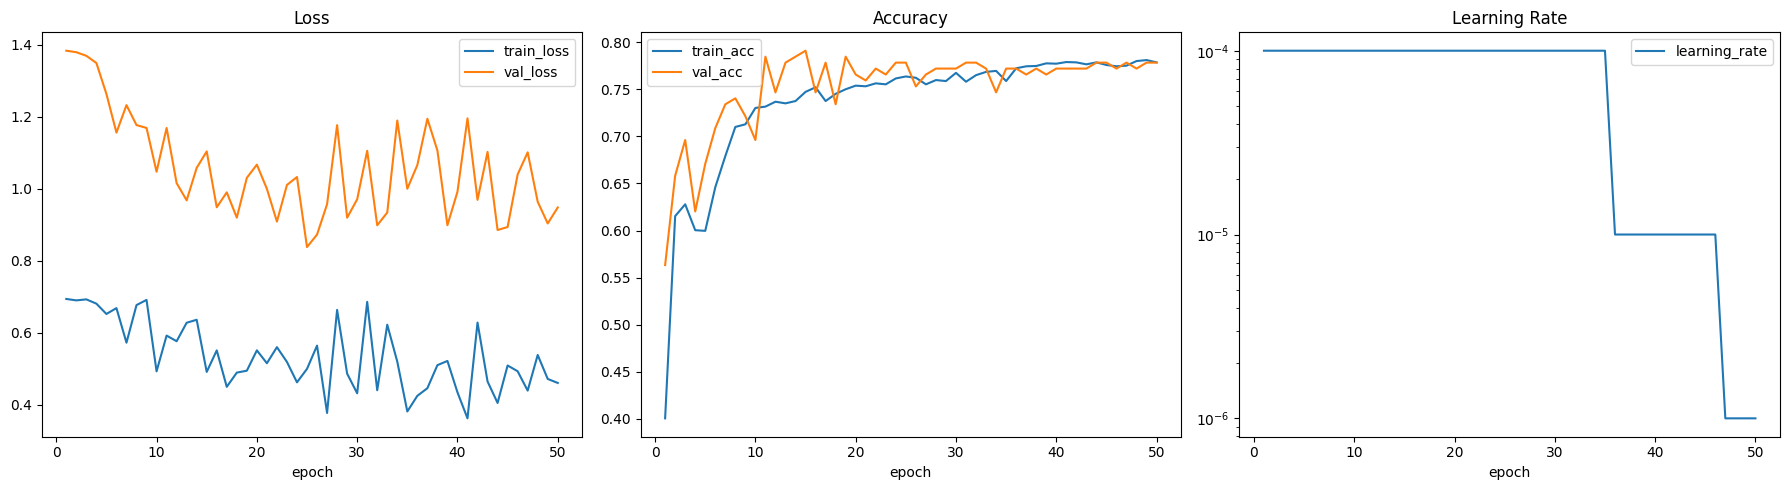

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

baseline_model_name = history['model'] == 'model1'

history[baseline_model_name].plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
history[baseline_model_name].plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
history[baseline_model_name].plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2], logy=True)

plt.tight_layout()
plt.show()

In [529]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

64

# Task 6: Transformers

https://huggingface.co/cardiffnlp/twitter-roberta-base-hate

1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [41]:
from roberta import roBERTa

Instantiate the class with seed and class weights to ensure reproducibility of the results.

In [43]:
model_card = 'cardiffnlp/twitter-roberta-base-hate'
transformer = roBERTa(model_card, class_weights=class_weights_tensor, seed=1337)

In case of previous runs, we can clear the cache to free up memory as well as call the garbage collector to free up memory.

In [44]:
transformer.clear_cache()

In [45]:
tokenizer = transformer.get_tokenizer()

In [46]:
train_data = transformer.get_dataset(train)
val_data = transformer.get_dataset(val)
test_data = transformer.get_dataset(test)

In [48]:
train_data = train_data.map(transformer.preprocess_text, batched=True)
val_data = val_data.map(transformer.preprocess_text, batched=True)
test_data = test_data.map(transformer.preprocess_text, batched=True)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [49]:
print(train_data)
print(test_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 286
})


In [51]:
transformer.show_encoded_text(data=train_data, idx=0)

Original: writing a uni essay in my local pub with a coffee random old man keep asking me drunk question when i m trying to concentrate amp end with good luck but you ll just end up getting married and not use it anyway <hashtag> is alive and well
Encoded: [0, 13293, 10, 542, 118, 14700, 11, 127, 400, 8881, 19, 10, 3895, 9624, 793, 313, 489, 1996, 162, 10789, 864, 77, 939, 475, 667, 7, 14410, 28127, 253, 19, 205, 6620, 53, 47, 19385, 95, 253, 62, 562, 2997, 8, 45, 304, 24, 6992, 28696, 25903, 10058, 15698, 16, 4299, 8, 157, 2]
Decoded: <s>writing a uni essay in my local pub with a coffee random old man keep asking me drunk question when i m trying to concentrate amp end with good luck but you ll just end up getting married and not use it anyway <hashtag> is alive and well</s>


In [53]:
model = transformer.get_model(num_labels=2, id2label={0: 'NEG', 1: 'POS'}, label2id={'NEG': 0, 'POS': 1})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
data_collator = transformer.get_data_collator()

In [55]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [56]:
training_args = transformer.get_training_args(
    output_dir="models",                 # where to save model
    learning_rate=5e-6,
    per_device_train_batch_size=BATCH_SIZE,         # accelerate defines distributed training
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    weight_decay=1e-5,
    eval_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none',                    # disabling wandb (default)
    seed=transformer.seed,
    data_seed=transformer.seed
)

In [57]:
trainer = transformer.get_trainer(model, training_args, train_data, test_data, data_collator)

In [58]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.404476,0.811152,0.811189,0.819231,0.821131
2,No log,0.377718,0.816892,0.818182,0.816029,0.819792
3,No log,0.366528,0.838203,0.839161,0.837495,0.841915
4,No log,0.366163,0.848088,0.849650,0.847107,0.849603
5,No log,0.366967,0.837821,0.839161,0.836754,0.840228
6,No log,0.358695,0.845238,0.846154,0.844497,0.849008
7,No log,0.363466,0.851923,0.853147,0.850795,0.854415
8,No log,0.361547,0.848493,0.849650,0.847412,0.851290
9,No log,0.365027,0.848298,0.849650,0.847192,0.850446
10,No log,0.364799,0.848298,0.849650,0.847192,0.850446


TrainOutput(global_step=450, training_loss=0.30338853624131945, metrics={'train_runtime': 258.1659, 'train_samples_per_second': 111.169, 'train_steps_per_second': 1.743, 'total_flos': 1400785786518120.0, 'train_loss': 0.30338853624131945, 'epoch': 10.0})

In [63]:
test_predictions, test_labels = transformer.get_predictions(trainer, test_data)

In [64]:
test_metrics = transformer.compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.8452380952380952, 'accuracy': 0.8461538461538461, 'precision': 0.8444966705836271, 'recall': 0.8490079365079365}


# Task 7: Error Analysis

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

Confusion Matrix

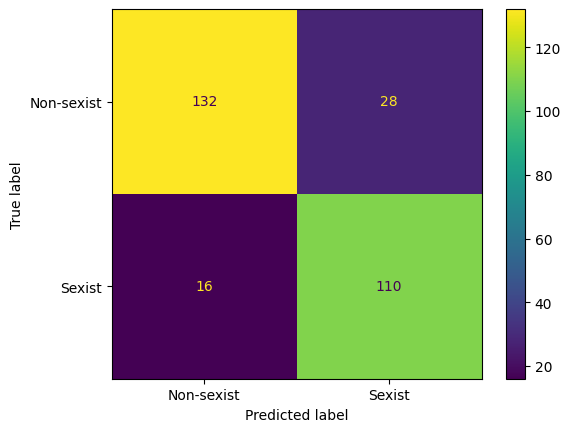

In [65]:
transformer.get_confusion_matrix(test_predictions, test_labels)

Precision-Recall Curve

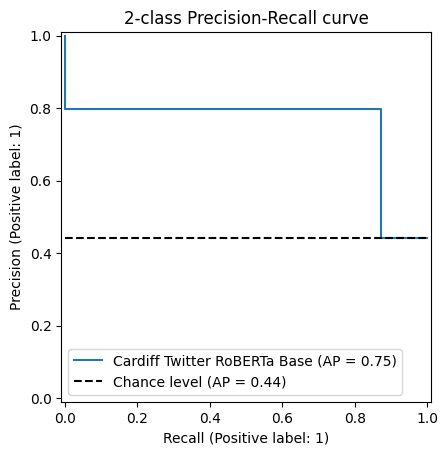

In [66]:
transformer.get_precision_recall(predictions=test_predictions, labels=test_labels)

Analysis on misclassified tweets, percentage of OOV words, original labels, etc.

In [597]:
test_copy.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


In [73]:
wrong_tweet_ids = transformer.review_errors(test_copy, test_data, test_predictions, test_labels, verbose=True)

Found 44 errors out of 286 samples.

                Contains OOV: {'gangbanged', 'wouldn', '<url>'}
                Tweet: i mean i do but wouldn t it be fun to get gangbanged together <url>
                Predicted: [-0.69483227  0.46991426]
                True Label: 0
                Raw Labels: ['NO', 'NO', 'NO', 'NO', 'YES', 'YES']

                

                Contains OOV: {'harassment', 'inferring', '<user>'}
                Tweet: <user> <user> sex a in gender harassment is what they are inferring
                Predicted: [-0.4800261   0.44028035]
                True Label: 0
                Raw Labels: ['NO', 'YES', 'NO', 'NO', 'NO', 'NO']

                

                Contains OOV: {'uvalde', '<user>', 'included', 'regrettably', '<url>', 'appreciate', 'harassment', 'unshocking', 'cyber', 'gunman'}
                Tweet: appreciate being included along with <user> on the uvalde gunman s history of cyber gender harassment regrettably unshocking <user> <url>
   

Common errrors spotted so far:

* Most of the errors are due to the fact that the model is not able to distinguish between the sexist and non-sexist tweets.
    * The predicted score is the opposite of the true score. This is a common error in classification tasks and can be due to the fact that the model is not able to learn the features that distinguish between the two classes.
    * All the missclassified tweets contain, at least, one word which is not in the vocabulary of the roBERTa. This for sure has an impact in the performance of the model since the model is not able to learn the embeddings for these words and loses information about the tweets. Indeed these OOVs are special tokens of the GloVe embeddings and are not present in the roBERTa vocabulary. This is a common problem when using pretrained embeddings. Moreover, this version of roBERTa has just a few special tokens as visible from the [map on huggingface](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate/blob/main/special_tokens_map.json).
    * A model which includes the special tokens for user mentions, url, elongations, etc. might perform better on this task since it will be able to learn the embeddings for these tokens and have better performances.

Get the slice of the test dataset where the model is failing to classify the tweets (wrong predictions). This can be useful to understand why the model is failing to classify the tweets and to have an idea of the features that the model is not able to learn.

In [569]:
test_copy[test_copy['id_EXIST'].isin(wrong_tweet_ids)].tweet.values

array(['“I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL',
       "@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring.",
       'Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf',
       "@EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??",
       '@Catoishere @HatClub @RahnniFitteds That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.',
       'He Tries To Expose This Gold Digger BUT IT BACKFIRES. | 90 Day Fiancée B... https://t.co/pz91AbJ0WS via @YouTube',
       '@MatrixPirate12 Well let me ask

# Task 8: Report

Wrap up your experiment in a short report (up to 2 pages).

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.